In [1]:
from pathlib import Path

import seaborn as sns
from scipy import interpolate
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from applefy.detections.contrast import Contrast

from applefy.utils.photometry import AperturePhotometryMode
from applefy.statistics import TTest, gaussian_sigma_2_fpf, \
    fpf_2_gaussian_sigma, LaplaceBootstrapTest

from applefy.utils.file_handling import load_adi_data
from applefy.utils import flux_ratio2mag, mag2flux_ratio

# 1. Load the data

In [2]:
hdf5_dataset = Path("/home/ipa/quanz/user_accounts/mbonse/2023_S4/30_data/HD22049_303_199_C-0065_C_/HD22049_303_199_C-0065_C_.hdf5")

In [3]:
science_data, angles, raw_psf_template_data = load_adi_data(
    hdf5_dataset=hdf5_dataset,
    data_tag="object_stacked_05",
    psf_template_tag="psf_template",
    para_tag="header_object_stacked_05/PARANG")

science_data = science_data[:, 7:-7, 7:-7]

In [4]:
dit_psf_template = 0.0042560
dit_science = 0.08

psf_template = np.median(raw_psf_template_data, axis=0)

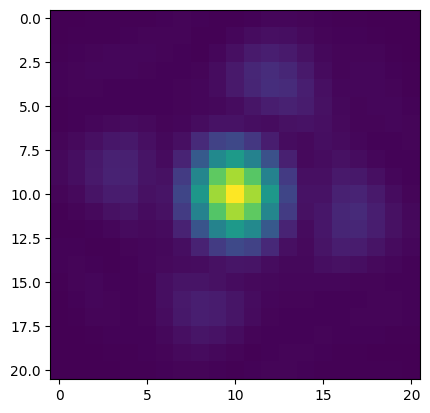

In [5]:
plt.imshow(psf_template)

In [6]:
psf_template = psf_template - np.min(psf_template)

0.0


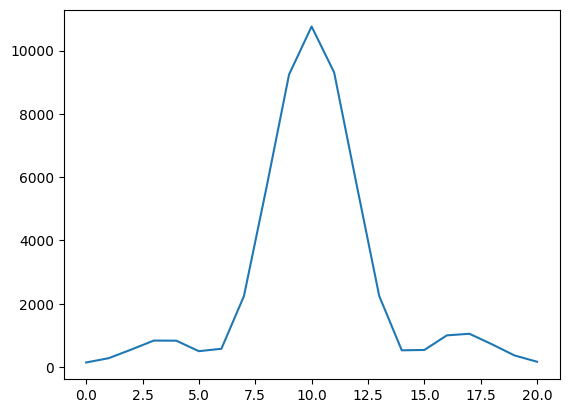

In [7]:
plt.plot(psf_template[10])
print(np.min(psf_template))

# 2. Fit the FWHM

In [8]:
from astropy.modeling.functional_models import Moffat2D
from astropy.modeling import fitting

In [9]:
# Fit the data using astropy.modeling
p_init = Moffat2D(amplitude=1e4, x_0=10, y_0=10)
fit_p = fitting.LevMarLSQFitter()

y, x = np.mgrid[:psf_template.shape[0],
                :psf_template.shape[1]]
p = fit_p(p_init, x, y, psf_template)

In [10]:
fwhm = np.round(p.fwhm, 1)
fwhm

3.6

Text(0.5, 1.0, 'Residual')

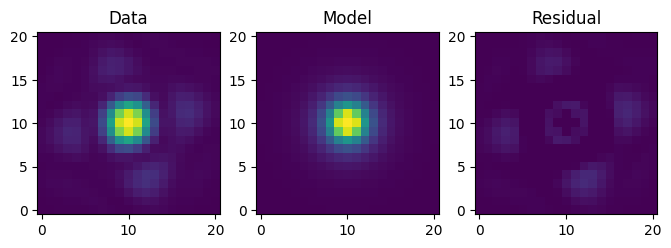

In [11]:
# Plot the data with the best-fit model
plt.figure(figsize=(8, 2.5))
plt.subplot(1, 3, 1)
plt.imshow(psf_template, 
           origin='lower', interpolation='nearest',
           vmin=0, vmax=1e4)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.imshow(p(x, y), 
           origin='lower', interpolation='nearest',
           vmin=0, vmax=1e4)
plt.title("Model")
plt.subplot(1, 3, 3)
plt.imshow(psf_template - p(x, y),
           origin='lower', interpolation='nearest',
          vmin=0, vmax=1e4)
plt.title("Residual")

# 3.  Contrast Grid Setup

In [12]:
contrast_grid_dir = Path(
    "/home/ipa/quanz/user_accounts/mbonse/"
    "2023_S4/70_results/pca_baseline/contrast_grid/") / hdf5_dataset.parent.name

contrast_grid_dir

PosixPath('/home/ipa/quanz/user_accounts/mbonse/2023_S4/70_results/pca_baseline/contrast_grid/HD22049_303_199_C-0065_C_')

In [13]:
contrast_instance = Contrast(
    science_sequence=science_data,
    psf_template=psf_template,
    parang_rad=angles,
    psf_fwhm_radius=fwhm / 2.,
    dit_psf_template=dit_psf_template,
    dit_science=dit_science,
    checkpoint_dir=contrast_grid_dir)

## 3.2 Design fake planet experiments

In [14]:
# fake planet brightness
flux_ratios_mag = np.linspace(7., 15, 17)
flux_ratios = mag2flux_ratio(flux_ratios_mag)

print("Brightness of fake planets in mag: " + str(flux_ratios_mag))
print("Planet-to-star flux ratio: " + str(flux_ratios))

Brightness of fake planets in mag: [ 7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15. ]
Planet-to-star flux ratio: [1.58489319e-03 1.00000000e-03 6.30957344e-04 3.98107171e-04
 2.51188643e-04 1.58489319e-04 1.00000000e-04 6.30957344e-05
 3.98107171e-05 2.51188643e-05 1.58489319e-05 1.00000000e-05
 6.30957344e-06 3.98107171e-06 2.51188643e-06 1.58489319e-06
 1.00000000e-06]


In [19]:
num_fake_planets = 3

contrast_instance.design_fake_planet_experiments(
    flux_ratios=flux_ratios,
    num_planets=num_fake_planets,
    overwrite=True)

Overwriting existing config files.


# 4. Run fake planet experiments

In [20]:
from applefy.wrappers.pynpoint import MultiComponentPCAPynPoint

In [21]:
components = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 
              25, 30, 35, 40, 45, 50, 60, 70, 80,
              90, 100, 120, 140, 160, 180, 200, 250, 300, 350, 400, 450, 500]

In [22]:
algorithm_function = MultiComponentPCAPynPoint(
    num_pcas=components,
    scratch_dir=Path("/scratch/user/mbonse/NACO_Archive") / hdf5_dataset.parent.name,
    num_cpus_pynpoint=1)

In [23]:
contrast_instance.run_fake_planet_experiments(
    algorithm_function=algorithm_function,
    num_parallel=16)

Running fake planet experiments...

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 868/868 [02:11<00:00,  6.58it/s]


[DONE]


# 5. Compute the contrast grid

In [24]:
# Use spaced pixel values
photometry_mode_planet = AperturePhotometryMode(
    "FS", # or "P"
    psf_fwhm_radius=fwhm/2.,
    search_area=0.5)
photometry_mode_noise = AperturePhotometryMode(
    "P",
    psf_fwhm_radius=fwhm/2.)

In [25]:
contrast_instance.prepare_contrast_results(
    photometry_mode_planet=photometry_mode_planet,
    photometry_mode_noise=photometry_mode_noise)

In [26]:
statistical_test = TTest()

In [27]:
contrast_curves_grid, contrast_grids = contrast_instance.compute_contrast_grids(
    statistical_test=statistical_test,
    num_cores=16,
    confidence_level_fpf=gaussian_sigma_2_fpf(5),
    num_rot_iter=20,
    safety_margin=1.0,
    pixel_scale=0.02718)

Computing contrast grid for PCA (002 components)
Computing contrast grid with multiprocessing:
.................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (004 components)
Computing contrast grid with multiprocessing:
.................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (006 components)
Computing contrast grid with multiprocessing:
...........................................................................................................................

.................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (120 components)
Computing contrast grid with multiprocessing:
.................................................................................................................................................................................................................................................................................................[DONE]
Computing contrast grid for PCA (140 components)
Computing contrast grid with multiprocessing:
..........................................................................................................................................................................................................................

In [28]:
contrast_curves_grid

,,PCA (002 components),PCA (004 components),PCA (006 components),PCA (008 components),PCA (010 components),PCA (012 components),PCA (014 components),PCA (016 components),PCA (018 components),PCA (020 components),...,PCA (140 components),PCA (160 components),PCA (180 components),PCA (200 components),PCA (250 components),PCA (300 components),PCA (350 components),PCA (400 components),PCA (450 components),PCA (500 components)
separation [$FWHM$],separation [arcsec],,,,,,,,,,,,,,,,,,,,,
1.0,0.097848,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
2.0,0.195696,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
3.0,0.293544,inf,inf,0.001477,0.001526,0.001220,0.000958,0.000961,0.000802,0.000899,0.001180,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
4.0,0.391392,0.001411,0.000800,0.000620,0.000549,0.000531,0.000463,0.000432,0.000420,0.000355,0.000290,...,0.000236,0.000339,inf,inf,inf,inf,inf,inf,inf,inf
5.0,0.489240,0.000881,0.000492,0.000396,0.000359,0.000348,0.000318,0.000275,0.000262,0.000236,0.000202,...,0.000051,0.000060,0.000097,0.000106,0.000373,inf,inf,inf,inf,inf
6.0,0.587088,0.000605,0.000352,0.000289,0.000265,0.000251,0.000214,0.000205,0.000191,0.000172,0.000155,...,0.000036,0.000035,0.000031,0.000027,0.000040,0.000135,0.000597,inf,inf,inf
7.0,0.684936,0.000397,0.000236,0.000202,0.000147,0.000141,0.000121,0.000113,0.000106,0.000095,0.000086,...,0.000019,0.000015,0.000016,0.000020,0.000022,0.000044,0.000083,0.000132,0.000134,0.000173
8.0,0.782784,0.000222,0.000132,0.000105,0.000090,0.000084,0.000075,0.000070,0.000066,0.000060,0.000055,...,0.000023,0.000021,0.000019,0.000019,0.000018,0.000017,0.000025,0.000036,0.000034,0.000050
9.0,0.880632,0.000115,0.000068,0.000052,0.000040,0.000038,0.000035,0.000034,0.000034,0.000033,0.000032,...,0.000012,0.000011,0.000010,0.000009,0.000010,0.000011,0.000016,0.000020,0.000025,0.000025


# 6. Plot the Contrast Grid

In [29]:
example_grid = contrast_grids["PCA (030 components)"]

# convert FPF to Gaussian Sigma
example_grid = example_grid.applymap(fpf_2_gaussian_sigma)

# convert flux_ratio to mag
example_grid.index = flux_ratio2mag(example_grid.index)
example_grid

separation [FWHM],1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0
flux_ratio,,,,,,,,,,,,,,,,,
7.0,1.133485,3.936065,5.448225,8.707012,9.738701,8.918175,9.537211,11.638845,12.691382,11.807150,14.022670,14.609869,15.167120,15.954514,16.648067,17.207345,17.724265
7.5,0.881190,2.843206,5.595005,8.271595,9.465043,8.792721,9.499653,11.729853,12.525323,11.786323,14.117448,14.599382,15.158122,15.920852,16.642987,17.211336,17.732161
8.0,0.861564,1.805564,4.985449,7.381559,9.098146,8.595664,9.409576,11.491525,12.412047,11.925567,13.895173,14.557051,15.064685,15.840060,16.646796,17.223192,17.589373
8.5,0.781379,0.635962,4.464014,6.752606,8.312706,8.316130,9.179656,11.122761,12.073447,11.850887,14.097450,14.288116,15.004400,15.967726,16.644440,16.829708,17.659912
9.0,0.712018,0.507521,3.588501,6.125386,7.434597,7.725219,8.927469,10.658800,11.811148,11.643585,13.903009,14.514408,15.042090,15.921231,16.595673,17.240712,17.757079
9.5,0.646811,0.435214,3.038576,4.883240,6.145864,6.814905,8.259846,9.729961,11.114474,11.411389,13.820350,14.548725,15.025552,15.914297,16.574058,17.194792,17.705008
10.0,0.586228,0.268070,2.809056,3.501117,4.641479,5.466947,7.208533,8.299131,9.981028,10.957238,13.235679,14.231096,14.717401,15.664113,16.381305,17.124033,17.624555
10.5,0.555725,0.250575,2.190691,2.375367,3.151517,3.869264,5.871226,6.620509,8.447798,10.093466,12.222761,13.528647,14.203608,15.325921,16.118754,16.825324,17.299588
11.0,0.548062,0.244888,2.137817,1.889228,2.159150,2.315862,4.457135,4.993611,6.974748,8.592892,10.800701,12.263233,13.101645,14.297373,15.322268,16.108992,16.459996


In [30]:
def plot_contrast_grid(
    contrast_grid_axis,
    colorbar_axis,
    contrast_grid):

    c_bar_kargs = dict(
        orientation = "vertical",
        label = r"Confidence [$\sigma_{\mathcal{N}}$]")

    heat = sns.heatmap(
        contrast_grid,
        vmax=2, vmin=7,
        annot=True,
        cmap="YlGnBu",
        ax=contrast_grid_axis,
        cbar_ax=colorbar_axis,
        cbar_kws=c_bar_kargs)

    ylabels = ['{:.1f}'.format(float(x.get_text()))
               for x in heat.get_yticklabels()]
    _=heat.set_yticklabels(ylabels)

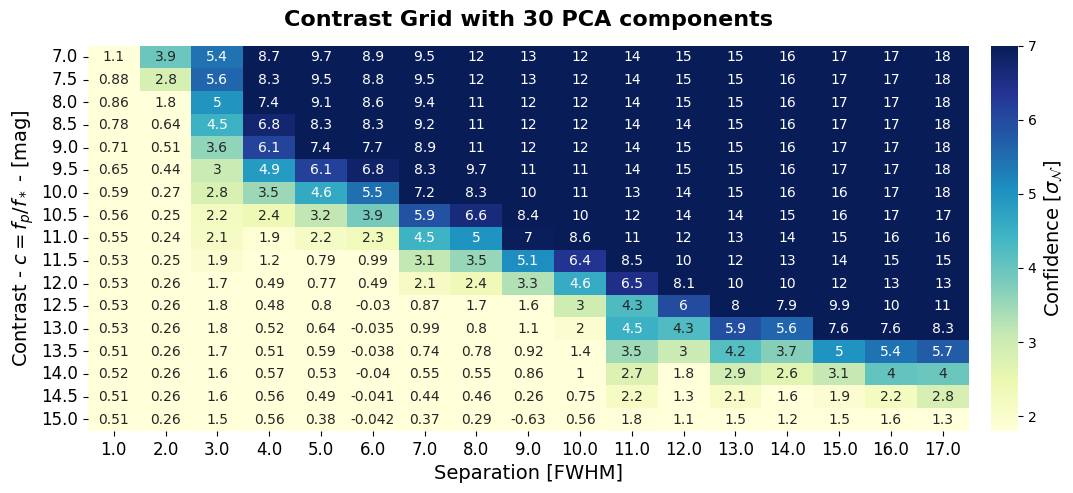

In [31]:
fig = plt.figure(figsize=(12, 5))

gs0 = fig.add_gridspec(1, 1)
gs0.update(wspace=0.0, hspace=0.2)
gs1 = gridspec.GridSpecFromSubplotSpec(
    1, 2, subplot_spec = gs0[0],
    wspace=0.05, width_ratios=[1, 0.03])

# All axis we need
contrast_ax = fig.add_subplot(gs1[0])
colorbar_ax = fig.add_subplot(gs1[1])

# Plot the contrast grid
plot_contrast_grid(
    contrast_grid_axis=contrast_ax,
    colorbar_axis=colorbar_ax,
    contrast_grid=example_grid)

colorbar_ax.yaxis.label.set_size(14)

contrast_ax.set_ylabel(
    "Contrast - $c = f_p / f_*$ - [mag]", size=14)
contrast_ax.set_xlabel(
    r"Separation [FWHM]", size=14)
contrast_ax.set_title(
    "Contrast Grid with 30 PCA components",
    fontsize=16,
    fontweight="bold",
    y=1.03)

contrast_ax.tick_params(
    axis='both',
    which='major',
    labelsize=12)

# Save the figure
fig.patch.set_facecolor('white')

# 7. Plot the contrast curves

In [32]:
# compute the overall best contrast curve
overall_best = np.min(contrast_curves_grid.values, axis=1)

In [33]:
# Find one color for each number of PCA components used.
colors = sns.color_palette(
    "rocket_r",
    n_colors=len(contrast_curves_grid.columns))
colors

[(0.97628674, 0.87986189, 0.8057883),
 (0.97169389, 0.83320847, 0.73716071),
 (0.96810471, 0.78634563, 0.66773889),
 (0.96592829, 0.73844258, 0.60053991),
 (0.96492035, 0.69534192, 0.5451917),
 (0.96388426, 0.64484214, 0.4861196),
 (0.96228344, 0.59304598, 0.43145271),
 (0.95964538, 0.53983991, 0.38092784),
 (0.95626788, 0.49187351, 0.33985601),
 (0.95085121, 0.43500005, 0.29722817),
 (0.94291042, 0.37549479, 0.26369821),
 (0.93078135, 0.31373977, 0.24468803),
 (0.9144225, 0.26028902, 0.24369359),
 (0.88731387, 0.20469941, 0.25769539),
 (0.85281737, 0.15657772, 0.27909826),
 (0.81291606, 0.11645784, 0.30213802),
 (0.77344838, 0.09405684, 0.32136808),
 (0.72398193, 0.08688725, 0.33943958),
 (0.67159578, 0.09306598, 0.35159077),
 (0.61792306, 0.10325288, 0.35760108),
 (0.57077365, 0.11135597, 0.35827146),
 (0.51728314, 0.1179558, 0.35453252),
 (0.46461238, 0.12123063, 0.34667231),
 (0.41282936, 0.12164769, 0.33467689),
 (0.36827206, 0.11993653, 0.32076656),
 (0.31826327, 0.1157429, 0.30100076),
 (0.26930915, 0.1091727, 0.2772502),
 (0.22150014, 0.10013944, 0.2497868),
 (0.18065495, 0.09009031, 0.22303512),
 (0.13501631, 0.07585609, 0.19044109),
 (0.09011319, 0.05808059, 0.15797687),
 (0.04447016, 0.03648425, 0.12631831)]

In [34]:
separations_arcsec = contrast_curves_grid.reset_index(level=0).index
separations_FWHM = contrast_curves_grid.reset_index(level=1).index

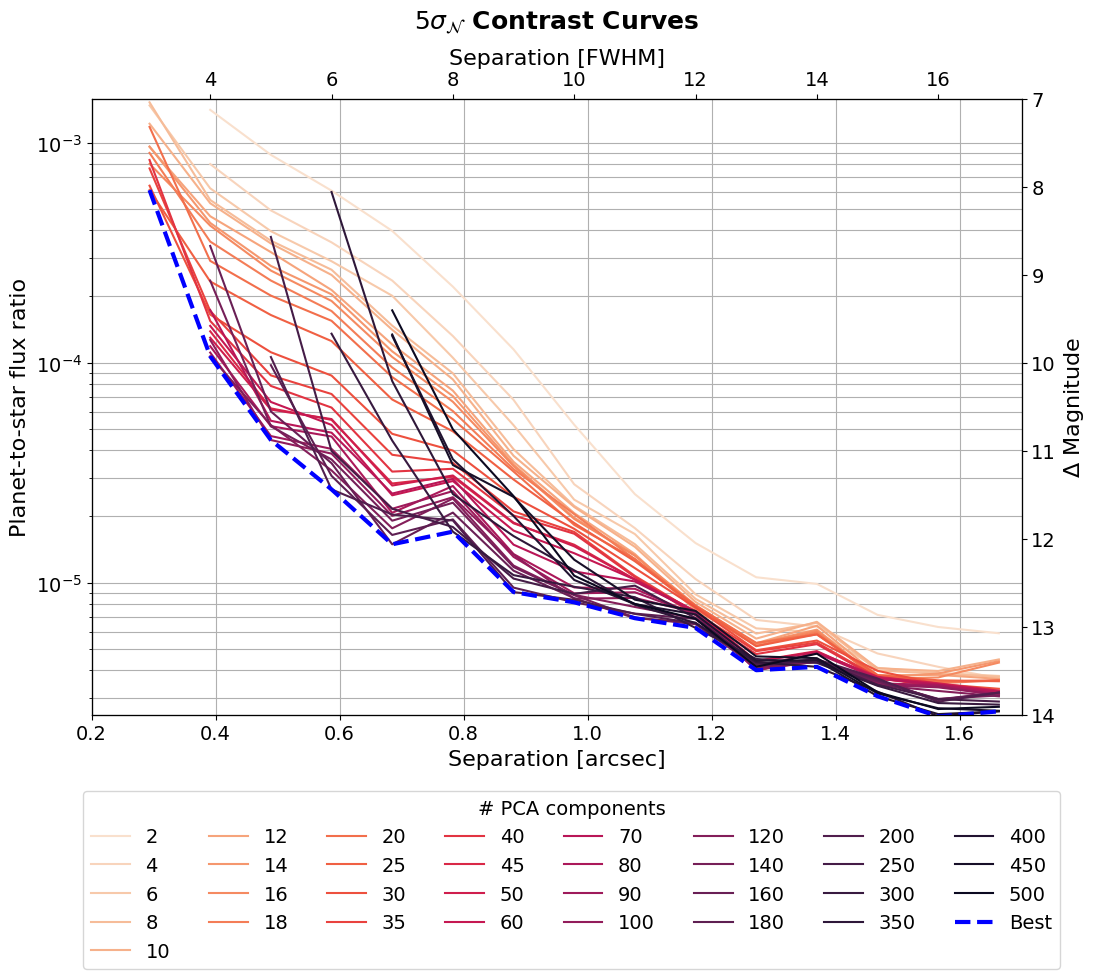

In [35]:
# 1.) Create Plot Layout
fig = plt.figure(constrained_layout=False, figsize=(12, 8))
gs0 = fig.add_gridspec(1, 1)
axis_contrast_curvse = fig.add_subplot(gs0[0, 0])


# ---------------------- Create the Plot --------------------
i = 0 # color picker

for tmp_model in contrast_curves_grid.columns:

    num_components = int(tmp_model[5:9])
    tmp_flux_ratios = contrast_curves_grid.reset_index(
        level=0)[tmp_model].values

    axis_contrast_curvse.plot(separations_arcsec,
                              tmp_flux_ratios,
                              color = colors[i],
                              label=num_components)
    i+=1

axis_contrast_curvse.set_yscale("log")
# ------------ Plot the overall best -------------------------
axis_contrast_curvse.plot(
    separations_arcsec,
    overall_best,
    color = "blue",
    lw=3,
    ls="--",
    label="Best")

# ------------- Double axis and limits -----------------------
lim_mag_y = (14, 7)
lim_arcsec_x = (0.2, 1.7)
sep_lambda_arcse = interpolate.interp1d(
    separations_arcsec,
    separations_FWHM,
    fill_value='extrapolate')

axis_contrast_curvse_mag = axis_contrast_curvse.twinx()
axis_contrast_curvse_mag.plot(
    separations_arcsec,
    flux_ratio2mag(tmp_flux_ratios),
    alpha=0.)
axis_contrast_curvse_mag.invert_yaxis()

axis_contrast_curvse_lambda = axis_contrast_curvse.twiny()
axis_contrast_curvse_lambda.plot(
    separations_FWHM,
    tmp_flux_ratios,
    alpha=0.)

axis_contrast_curvse.grid(which='both')
axis_contrast_curvse_mag.set_ylim(*lim_mag_y)
axis_contrast_curvse.set_ylim(
    mag2flux_ratio(lim_mag_y[0]),
    mag2flux_ratio(lim_mag_y[1]))

axis_contrast_curvse.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_mag.set_xlim(
    *lim_arcsec_x)
axis_contrast_curvse_lambda.set_xlim(
    *sep_lambda_arcse(lim_arcsec_x))

# ----------- Labels and fontsizes --------------------------

axis_contrast_curvse.set_xlabel(
    r"Separation [arcsec]", size=16)
axis_contrast_curvse_lambda.set_xlabel(
    r"Separation [FWHM]", size=16)

axis_contrast_curvse.set_ylabel(
    r"Planet-to-star flux ratio", size=16)
axis_contrast_curvse_mag.set_ylabel(
    r"$\Delta$ Magnitude", size=16)

axis_contrast_curvse.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_lambda.tick_params(
    axis='both', which='major', labelsize=14)
axis_contrast_curvse_mag.tick_params(
    axis='both', which='major', labelsize=14)

axis_contrast_curvse_mag.set_title(
    r"$5 \sigma_{\mathcal{N}}$ Contrast Curves",
    fontsize=18, fontweight="bold", y=1.1)

# --------------------------- Legend -----------------------
handles, labels = axis_contrast_curvse.\
    get_legend_handles_labels()

leg1 = fig.legend(handles, labels,
                  bbox_to_anchor=(0.11, -0.22),
                  fontsize=14,
                  title="# PCA components",
                  loc='lower left', ncol=8)

_=plt.setp(leg1.get_title(),fontsize=14)

# 8. Best number of PCA

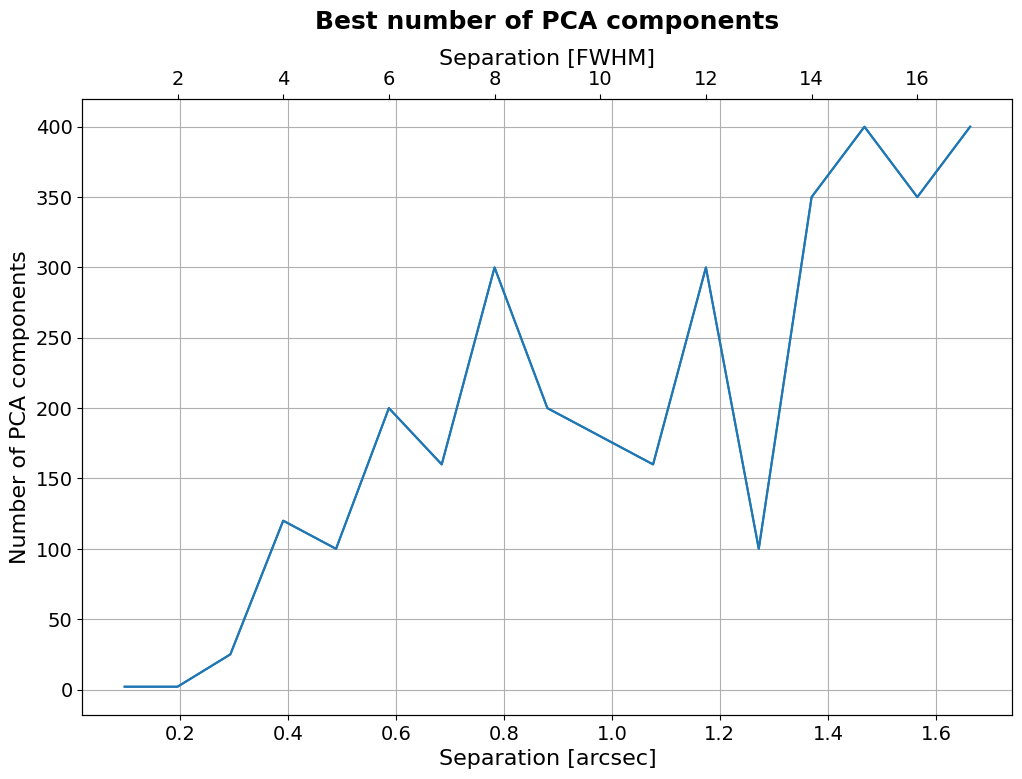

In [36]:
plt.figure(figsize=(12, 8))

plt.plot(separations_arcsec,
         np.array(components)[np.argmin(
             contrast_curves_grid.values,
             axis=1)],)

plt.title(r"Best number of PCA components",
          fontsize=18, fontweight="bold", y=1.1)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel("Separation [arcsec]", fontsize=16)
plt.ylabel("Number of PCA components", fontsize=16)

plt.grid()
ax2 = plt.twiny()
ax2.plot(separations_FWHM,
         np.array(components)[
             np.argmin(contrast_curves_grid.values, axis=1)],)
ax2.set_xlabel("Separation [FWHM]", fontsize=16)
ax2.tick_params(axis='both', which='major', labelsize=14)